This script tries to classify water potability in binary way. The used dataset is the one below:

https://www.kaggle.com/datasets/uom190346a/water-quality-and-potability

An accuracy of 96% is reached thanks to a five layers DNN

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import csv
import numpy as np
from sklearn.utils import shuffle

In [2]:
ds_features = []
labels = []

with open('/kaggle/input/water-quality-and-potability/water_potability.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    header = next(reader) #skip first line
    for row in reader:
        if('' not in row):
            ds_features.append(row[:-1])
            labels.append(int(row[-1]))

In [3]:
ds_features = np.array(ds_features, dtype='float32')
labels = np.array(labels, dtype='int')
print(ds_features.shape)
print(labels.shape)

(2011, 9)
(2011,)


In [4]:
#let's augment data by adding 1% std_dev local Gaussian Noise
for __ in range(3):
    tmp_feature = ds_features
    tmp_feature = [(item + np.random.normal(item, item*0.01)) for item in ds_features]
    ds_features = np.concatenate((ds_features, tmp_feature))
    labels = np.concatenate((labels, labels))
print(ds_features.shape)
print(labels.shape)

(16088, 9)
(16088,)


In [5]:
#features regularization, remove mean, reshape with std_dev
#and rescale (normalization) by highest feature value
for index in range(len(ds_features[0])):
    ds_features[:,index] -= ds_features[:,index].mean()
    ds_features[:,index] /= ds_features[:,index].std()
    ds_features[:,index] /= max(ds_features[:,index])

In [6]:
#SPLIT in training and validation sets
X, Y = shuffle(ds_features, labels)
split_ratio = 0.95
X_train, Y_train = X[:int(split_ratio*X.shape[0])], Y[:int(split_ratio*Y.shape[0])]
X_valid, Y_valid = X[int(split_ratio*X.shape[0]):], Y[int(split_ratio*Y.shape[0]):]
print(X_train.shape)
print(X_valid.shape)


(15283, 9)
(805, 9)


In [7]:
#model definition
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation = 'relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(512, activation = 'relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(512, activation = 'relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(64, activation = 'relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')])

In [8]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    metrics=['accuracy'])

In [9]:
class EarlyStop(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('loss') is not None and logs.get('accuracy') > 0.96 and logs.get('val_accuracy')  > 0.96:                 
            print("\nReached wanted accuracy so cancelling training!")
            self.model.stop_training = True
early_stop_cb = EarlyStop()

In [10]:
epochs = 1000
history = model.fit(
            X_train, Y_train,
            epochs=epochs,
            batch_size=512,
            validation_data=(X_valid, Y_valid),
            verbose=1,
            callbacks=[early_stop_cb])

Epoch 1/1000
30/30 [==============================] - 2s 37ms/step - loss: 0.6699 - accuracy: 0.6005 - val_loss: 0.6413 - val_accuracy: 0.6547
Epoch 2/1000
30/30 [==============================] - 1s 30ms/step - loss: 0.6393 - accuracy: 0.6419 - val_loss: 0.6141 - val_accuracy: 0.6646
Epoch 3/1000
30/30 [==============================] - 1s 31ms/step - loss: 0.6156 - accuracy: 0.6662 - val_loss: 0.5872 - val_accuracy: 0.6870
Epoch 4/1000
30/30 [==============================] - 1s 31ms/step - loss: 0.6004 - accuracy: 0.6695 - val_loss: 0.5780 - val_accuracy: 0.6894
Epoch 5/1000
30/30 [==============================] - 1s 31ms/step - loss: 0.5822 - accuracy: 0.6890 - val_loss: 0.5743 - val_accuracy: 0.6807
Epoch 6/1000
30/30 [==============================] - 1s 30ms/step - loss: 0.5726 - accuracy: 0.6946 - val_loss: 0.5537 - val_accuracy: 0.7031
Epoch 7/1000
30/30 [==============================] - 1s 29ms/step - loss: 0.5606 - accuracy: 0.7007 - val_loss: 0.5603 - val_accuracy: 0.7093

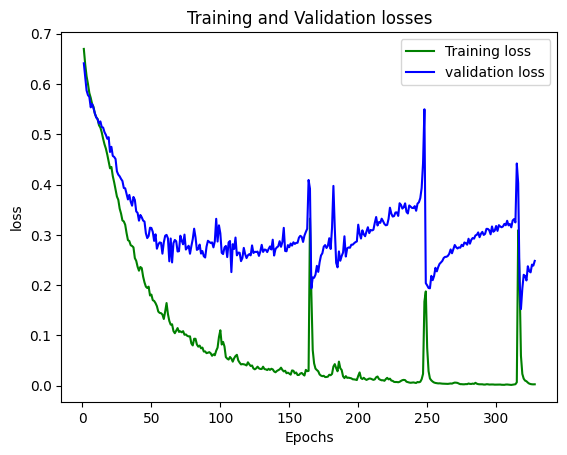

In [11]:
epoch_range = np.arange(1, history.epoch[-1]+2)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epoch_range, train_loss, 'g', label='Training loss')
plt.plot(epoch_range, val_loss, 'b', label='validation loss')
plt.title('Training and Validation losses')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

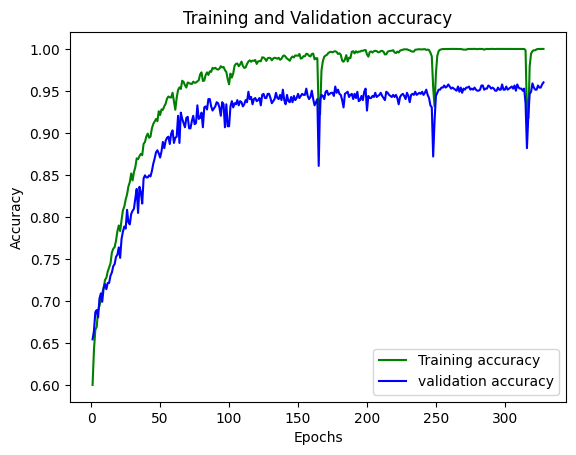

In [12]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epoch_range, train_accuracy, 'g', label='Training accuracy')
plt.plot(epoch_range, val_accuracy, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()